In [74]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from datasets import load_dataset
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

In [75]:

# Specify the root folder that contains sub-folders with audio files
root = '..\\..\\sound-propagation-simulation\\dataset'

# Create empty lists to store waveforms, sample rates and labels
waveforms = []
sample_rates = []
labels = []

# Loop over the sub-folders in the root folder
for folder in os.listdir(root):
    # Get the label from the folder name
    label = folder
    # Loop over the audio files in each sub-folder
    for filename in glob.glob(os.path.join(root, folder, '*.wav')):
        try:
            # Load an audio file as a tensor and its sample rate
            waveform, sample_rate = torchaudio.load(filename)
            # Append them to the lists
            waveforms.append(waveform)
            sample_rates.append(sample_rate)
            labels.append(label)
        except Exception as e:
            print(e)

Error opening '..\\..\\sound-propagation-simulation\\dataset\\fromlefttoleft\\record39.71317.wav': Format not recognised.
Error opening '..\\..\\sound-propagation-simulation\\dataset\\fromlefttoright\\record181.1908.wav': Format not recognised.
Error opening '..\\..\\sound-propagation-simulation\\dataset\\fromlefttoright\\record21.38363.wav': Format not recognised.
Error opening '..\\..\\sound-propagation-simulation\\dataset\\fromrighttoleft\\record200.5369.wav': Format not recognised.
Error opening '..\\..\\sound-propagation-simulation\\dataset\\fromrighttoleft\\record58.07485.wav': Format not recognised.
Error opening '..\\..\\sound-propagation-simulation\\dataset\\fromrighttoright\\record214.7699.wav': Format not recognised.
Error opening '..\\..\\sound-propagation-simulation\\dataset\\fromrighttoright\\record249.3075.wav': Format not recognised.


In [76]:
# crop the waveforms to 48000 samples
waveforms_cropped = [waveform[:, :44000] for waveform in waveforms]

In [77]:
# create tensors from the lists
waveforms_tensor = torch.stack(waveforms_cropped)
sample_rates = torch.tensor(sample_rates)
print(waveforms_tensor.shape)
# convert the labels to integers
label_to_int = {label: i for i, label in enumerate(set(labels))}
int_labels = [label_to_int[label] for label in labels]
int_labels = torch.tensor(int_labels)
print(int_labels.shape)



torch.Size([239, 2, 44000])
torch.Size([239])


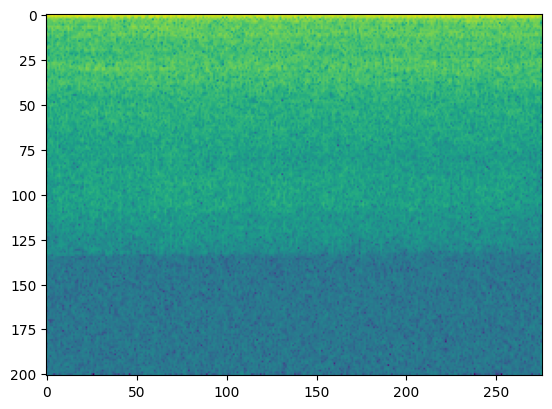

In [78]:
# convert the waveforms to spectrograms
spectrograms = [F.spectrogram(waveform, pad=0, window=torch.hann_window(400), n_fft=400, hop_length=160, win_length=400, power=2.0, normalized=False) for waveform in waveforms_tensor]
spectrograms = torch.stack(spectrograms)
# plot an example spectrogram
plt.imshow(spectrograms[0].log2()[0,:,:].detach().numpy())
plt.show()


In [79]:
# dataloader
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(spectrograms, int_labels)
# split the dataset into labels and features
X = dataset.tensors[0]
y = dataset.tensors[1]

# split the dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
batch_size = 16
# create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



In [80]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

# input shape (191, 2, 201, 276)
# output shape (1, 4)
class CNN(nn.Module):
    def __init__(self, num_classes, num_channels=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*25*34, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten the output of the last convolutional layer
        x = torch.flatten(x, 1)
        # Apply dropout and fully connected layers with ReLU activation
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [82]:
# Create a CNN model
model = CNN(4)
# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# print the model
summary(model, (2, 201, 276))
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for i in range(0,len(train_loader), batch_size):
        # Get the inputs and labels
        inputs, labels = next(iter(train_loader))
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # print the loss
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, loss.item()))
    print('Accuracy: {:.2f}%'.format((outputs.argmax(1) == labels).sum().item() / len(labels) * 100))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 201, 276]             608
         MaxPool2d-2         [-1, 32, 100, 138]               0
            Conv2d-3         [-1, 64, 100, 138]          18,496
         MaxPool2d-4           [-1, 64, 50, 69]               0
            Conv2d-5           [-1, 64, 50, 69]          36,928
         MaxPool2d-6           [-1, 64, 25, 34]               0
           Dropout-7                [-1, 54400]               0
            Linear-8                  [-1, 128]       6,963,328
           Dropout-9                  [-1, 128]               0
           Linear-10                    [-1, 4]             516
Total params: 7,019,876
Trainable params: 7,019,876
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.42
Forward/backward pass size (MB): 27.85
Params size (MB): 26.78
Estim

KeyboardInterrupt: 

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the test images: 18.75 %
